<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/full_net_regularised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 384 (delta 71), reused 49 (delta 21), pack-reused 245
Receiving objects: 100% (384/384), 152.26 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Checking out files: 100% (109/109), done.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
('RAM Free: 12.9 GB', ' | Proc size: 152.9 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [6]:
from common import *
!chmod +x setup.sh
!./setup.sh

--2019-03-14 09:39:31--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.26.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:39:31--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:39:31--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, HPatchesRegularised, DataGeneratorDescRegularised, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation
from keras.layers import Layer, Lambda

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

def run_sobel(image):
  return tf.image.sobel_edges(image)[:,:,:,0]
      

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_full_model(shape,stn_init=None):  
    #shape = (32, 32, 1)

    init_weights = keras.initializers.he_normal()
    # input 
    inputs = Input(shape)
    
    # denoise network
    depth1  = 32
    conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # convolution layers
    conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)

    # network
    net1 = Subtract()([conv1_1, conv1_2])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_3])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_5])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_7])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_9])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_11])
    net1 = BatchNormalization()(net1)  

    # convolution layers
    depth2 = 16
    conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)

    # network
    net2 = Subtract()([conv2_1, conv2_2])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_3])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_5])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_7])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_9])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_11])
    net2 = BatchNormalization()(net2)  

    # convolution layers
    depth3 = 8
    conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)

    # network
    net3 = Subtract()([conv3_1, conv3_2])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_3])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_5])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_7])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_9])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_11])
    net3 = BatchNormalization()(net3)  

    #net = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(net3)
  
    
    # stn network    
    locnet = MaxPooling2D(pool_size=(2, 2))(net3)
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('sigmoid')(locnet)
    weights = get_initial_weights(100)
    locnet = Dense(6, weights=weights)(locnet)
    stn    = BilinearInterpolation(shape[:-1])([net3, locnet])
    
    if stn_init:
      stn.set_weights(stn_init.get_weights())
      
    # sobel
    sobel = Lambda(run_sobel)(net3)
    
    # features in
    l2net = concatenate([ net3, stn , sobel ], axis = -1)
    
    # L2 Net    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 8, padding='valid', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)

    l2net = Reshape((128,))(l2net)
  
    l2net = Model(inputs = inputs, outputs = l2net)
    
    descriptor_model = Sequential()
    descriptor_model.add(l2net)
    
    return descriptor_model

    
  
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_full_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
from keras.layers import Lambda

shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_full_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)
alphaIn = Input(shape=(1,), name='alpha')

def triplet_loss_regularised(x):  
  a, p, n, _alpha = x

  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)

  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha[0]), axis = 1)


loss = Lambda(triplet_loss_regularised)([ea, ep, en, alphaIn])

descriptor_model_trip = Model(inputs=[xa, xp, xn, alphaIn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [12]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs))
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatchesRegularised(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=False)
# Creating training generator
training_generator = DataGeneratorDescRegularised(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000, batch_size=500)
# Creating validation generator
val_generator = DataGeneratorDescRegularised(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000, batch_size=500)

Using noisy patches
100%|██████████| 116/116 [00:33<00:00,  2.20it/s]

  2%|▏         | 2226/100000 [00:00<00:04, 22259.07it/s]

100%|██████████| 100000/100000 [00:01<00:00, 55243.40it/s]


(500, 1)
Using noisy patches
100%|██████████| 116/116 [00:20<00:00,  5.56it/s]

 36%|███▌      | 3557/10000 [00:00<00:00, 35568.93it/s]

100%|██████████| 10000/10000 [00:00<00:00, 50328.65it/s]

(500, 1)


In [13]:
# callbacks
callbacks = [
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=100, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
199/200 [============================>.] - ETA: 1s - loss: 0.2637

 94%|█████████▍| 9385/10000 [00:00<00:00, 45944.09it/s]

200/200 [==============================] - 215s 1s/step - loss: 0.2632 - val_loss: 0.2454


100%|██████████| 10000/10000 [00:00<00:00, 37642.09it/s]



Epoch 00001: val_loss improved from inf to 0.24542, saving model to data/descriptor_model.weights.01-0.25.hdf5
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.2017

100%|██████████| 10000/10000 [00:00<00:00, 37713.37it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.2016 - val_loss: 0.2332



Epoch 00002: val_loss improved from 0.24542 to 0.23317, saving model to data/descriptor_model.weights.02-0.23.hdf5
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.1829

100%|██████████| 10000/10000 [00:00<00:00, 44488.16it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.1829 - val_loss: 0.2067

Epoch 00003: val_loss improved from 0.23317 to 0.20666, saving model to data/descriptor_model.weights.03-0.21.hdf5
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.1684

 46%|████▌     | 4592/10000 [00:00<00:00, 45919.17it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.1683 - val_loss: 0.1920


100%|██████████| 10000/10000 [00:00<00:00, 45957.57it/s]



Epoch 00004: val_loss improved from 0.20666 to 0.19200, saving model to data/descriptor_model.weights.04-0.19.hdf5
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.1606

 94%|█████████▍| 9385/10000 [00:00<00:00, 46416.44it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.1607 - val_loss: 0.1850


100%|██████████| 10000/10000 [00:00<00:00, 44383.32it/s]



Epoch 00005: val_loss improved from 0.19200 to 0.18501, saving model to data/descriptor_model.weights.05-0.19.hdf5
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.1523

 97%|█████████▋| 9748/10000 [00:00<00:00, 46311.07it/s]

200/200 [==============================] - 197s 983ms/step - loss: 0.1524 - val_loss: 0.1879


100%|██████████| 10000/10000 [00:00<00:00, 45475.63it/s]



Epoch 00006: val_loss did not improve from 0.18501
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.1492

100%|██████████| 10000/10000 [00:00<00:00, 36753.23it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.1492 - val_loss: 0.2049

Epoch 00007: val_loss did not improve from 0.18501
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.1442

100%|██████████| 10000/10000 [00:00<00:00, 45475.24it/s]

200/200 [==============================] - 196s 979ms/step - loss: 0.1442 - val_loss: 0.1736



Epoch 00008: val_loss improved from 0.18501 to 0.17358, saving model to data/descriptor_model.weights.08-0.17.hdf5
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.1388

100%|██████████| 10000/10000 [00:00<00:00, 43630.40it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.1389 - val_loss: 0.1876



Epoch 00009: val_loss did not improve from 0.17358
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.1353

100%|██████████| 10000/10000 [00:00<00:00, 44031.13it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.1353 - val_loss: 0.1755

Epoch 00010: val_loss did not improve from 0.17358
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.1323

100%|██████████| 10000/10000 [00:00<00:00, 44999.01it/s]

200/200 [==============================] - 195s 977ms/step - loss: 0.1325 - val_loss: 0.1624



Epoch 00011: val_loss improved from 0.17358 to 0.16239, saving model to data/descriptor_model.weights.11-0.16.hdf5
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.1273

 84%|████████▍ | 8450/10000 [00:00<00:00, 40930.23it/s]

200/200 [==============================] - 195s 977ms/step - loss: 0.1274 - val_loss: 0.1550

Epoch 00012: val_loss improved from 0.16239 to 0.15503, saving model to data/descriptor_model.weights.12-0.16.hdf5
Epoch 13/100


100%|██████████| 10000/10000 [00:00<00:00, 21396.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1262

100%|██████████| 10000/10000 [00:00<00:00, 43524.41it/s]

200/200 [==============================] - 196s 981ms/step - loss: 0.1262 - val_loss: 0.1587



Epoch 00013: val_loss did not improve from 0.15503
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.1217

100%|██████████| 10000/10000 [00:00<00:00, 43144.53it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.1217 - val_loss: 0.1537

Epoch 00014: val_loss improved from 0.15503 to 0.15370, saving model to data/descriptor_model.weights.14-0.15.hdf5
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.1211

 85%|████████▍ | 8478/10000 [00:00<00:00, 38904.45it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.1212 - val_loss: 0.1653


100%|██████████| 10000/10000 [00:00<00:00, 36828.48it/s]



Epoch 00015: val_loss did not improve from 0.15370
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.1179

100%|██████████| 10000/10000 [00:00<00:00, 45825.52it/s]

200/200 [==============================] - 195s 977ms/step - loss: 0.1180 - val_loss: 0.1547



Epoch 00016: val_loss did not improve from 0.15370
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.1162

100%|██████████| 10000/10000 [00:00<00:00, 35935.43it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.1162 - val_loss: 0.1595

Epoch 00017: val_loss did not improve from 0.15370
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.1169

100%|██████████| 10000/10000 [00:00<00:00, 45201.82it/s]

200/200 [==============================] - 196s 978ms/step - loss: 0.1169 - val_loss: 0.1493



Epoch 00018: val_loss improved from 0.15370 to 0.14927, saving model to data/descriptor_model.weights.18-0.15.hdf5
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.1147

100%|██████████| 10000/10000 [00:00<00:00, 43823.69it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.1147 - val_loss: 0.1498

Epoch 00019: val_loss did not improve from 0.14927
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.1128

100%|██████████| 10000/10000 [00:00<00:00, 42556.45it/s]


200/200 [==============================] - 196s 982ms/step - loss: 0.1128 - val_loss: 0.1456

Epoch 00020: val_loss improved from 0.14927 to 0.14565, saving model to data/descriptor_model.weights.20-0.15.hdf5
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.1122

100%|██████████| 10000/10000 [00:00<00:00, 35191.42it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.1121 - val_loss: 0.1481

Epoch 00021: val_loss did not improve from 0.14565
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.1091

100%|██████████| 10000/10000 [00:00<00:00, 43679.97it/s]

200/200 [==============================] - 196s 979ms/step - loss: 0.1092 - val_loss: 0.1381



Epoch 00022: val_loss improved from 0.14565 to 0.13810, saving model to data/descriptor_model.weights.22-0.14.hdf5
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.1057

100%|██████████| 10000/10000 [00:00<00:00, 43258.76it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.1057 - val_loss: 0.1416

Epoch 00023: val_loss did not improve from 0.13810
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.1067

100%|██████████| 10000/10000 [00:00<00:00, 36684.85it/s]

200/200 [==============================] - 196s 980ms/step - loss: 0.1067 - val_loss: 0.1357



Epoch 00024: val_loss improved from 0.13810 to 0.13570, saving model to data/descriptor_model.weights.24-0.14.hdf5
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.1069

100%|██████████| 10000/10000 [00:00<00:00, 37084.13it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.1069 - val_loss: 0.1371

Epoch 00025: val_loss did not improve from 0.13570
Epoch 26/100
199/200 [============================>.] - ETA: 0s - loss: 0.1061

100%|██████████| 10000/10000 [00:00<00:00, 44661.97it/s]

200/200 [==============================] - 196s 979ms/step - loss: 0.1061 - val_loss: 0.1332



Epoch 00026: val_loss improved from 0.13570 to 0.13325, saving model to data/descriptor_model.weights.26-0.13.hdf5
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.1037

100%|██████████| 10000/10000 [00:00<00:00, 45606.47it/s]

200/200 [==============================] - 196s 981ms/step - loss: 0.1035 - val_loss: 0.1408



Epoch 00027: val_loss did not improve from 0.13325
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.1024

100%|██████████| 10000/10000 [00:00<00:00, 45480.22it/s]

200/200 [==============================] - 196s 980ms/step - loss: 0.1024 - val_loss: 0.1362



Epoch 00028: val_loss did not improve from 0.13325
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.1016

 93%|█████████▎| 9317/10000 [00:00<00:00, 45421.01it/s]

200/200 [==============================] - 196s 979ms/step - loss: 0.1016 - val_loss: 0.1405


100%|██████████| 10000/10000 [00:00<00:00, 37062.86it/s]



Epoch 00029: val_loss did not improve from 0.13325
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0999

100%|██████████| 10000/10000 [00:00<00:00, 35163.22it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.0998 - val_loss: 0.1421

Epoch 00030: val_loss did not improve from 0.13325
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0999

 97%|█████████▋| 9743/10000 [00:00<00:00, 48647.05it/s]

200/200 [==============================] - 196s 980ms/step - loss: 0.0999 - val_loss: 0.1320


100%|██████████| 10000/10000 [00:00<00:00, 43993.53it/s]



Epoch 00031: val_loss improved from 0.13325 to 0.13204, saving model to data/descriptor_model.weights.31-0.13.hdf5
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0968

 64%|██████▍   | 6445/10000 [00:00<00:00, 32790.55it/s]

200/200 [==============================] - 196s 981ms/step - loss: 0.0967 - val_loss: 0.1315

Epoch 00032: val_loss improved from 0.13204 to 0.13147, saving model to data/descriptor_model.weights.32-0.13.hdf5
Epoch 33/100


100%|██████████| 10000/10000 [00:00<00:00, 19012.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0984

100%|██████████| 10000/10000 [00:00<00:00, 37851.55it/s]


200/200 [==============================] - 197s 985ms/step - loss: 0.0985 - val_loss: 0.1359

Epoch 00033: val_loss did not improve from 0.13147
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0949

100%|██████████| 10000/10000 [00:00<00:00, 43996.86it/s]

200/200 [==============================] - 196s 981ms/step - loss: 0.0949 - val_loss: 0.1334



Epoch 00034: val_loss did not improve from 0.13147
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0962

 85%|████████▍ | 8456/10000 [00:00<00:00, 41788.67it/s]

200/200 [==============================] - 196s 979ms/step - loss: 0.0961 - val_loss: 0.1281

Epoch 00035: val_loss improved from 0.13147 to 0.12806, saving model to data/descriptor_model.weights.35-0.13.hdf5
Epoch 36/100


100%|██████████| 10000/10000 [00:00<00:00, 20705.78it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0940

100%|██████████| 10000/10000 [00:00<00:00, 37518.25it/s]


200/200 [==============================] - 196s 981ms/step - loss: 0.0939 - val_loss: 0.1186

Epoch 00036: val_loss improved from 0.12806 to 0.11856, saving model to data/descriptor_model.weights.36-0.12.hdf5
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0935

100%|██████████| 10000/10000 [00:00<00:00, 46253.29it/s]

200/200 [==============================] - 197s 983ms/step - loss: 0.0936 - val_loss: 0.1373



Epoch 00037: val_loss did not improve from 0.11856
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0930

100%|██████████| 10000/10000 [00:00<00:00, 45035.30it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0929 - val_loss: 0.1196



Epoch 00038: val_loss did not improve from 0.11856
Epoch 39/100
199/200 [============================>.] - ETA: 0s - loss: 0.0960

100%|██████████| 10000/10000 [00:00<00:00, 36710.99it/s]

200/200 [==============================] - 198s 991ms/step - loss: 0.0960 - val_loss: 0.1209



Epoch 00039: val_loss did not improve from 0.11856
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0939

 90%|████████▉ | 8964/10000 [00:00<00:00, 45481.27it/s]

200/200 [==============================] - 199s 995ms/step - loss: 0.0939 - val_loss: 0.1281


100%|██████████| 10000/10000 [00:00<00:00, 36344.37it/s]



Epoch 00040: val_loss did not improve from 0.11856
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0897

 84%|████████▍ | 8388/10000 [00:00<00:00, 40538.32it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0898 - val_loss: 0.1180


100%|██████████| 10000/10000 [00:00<00:00, 24178.65it/s]


Epoch 00041: val_loss improved from 0.11856 to 0.11804, saving model to data/descriptor_model.weights.41-0.12.hdf5
Epoch 42/100


199/200 [============================>.] - ETA: 0s - loss: 0.0913

100%|██████████| 10000/10000 [00:00<00:00, 45649.36it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0913 - val_loss: 0.1252



Epoch 00042: val_loss did not improve from 0.11804
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0904

100%|██████████| 10000/10000 [00:00<00:00, 45697.80it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0903 - val_loss: 0.1198



Epoch 00043: val_loss did not improve from 0.11804
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0886

 90%|████████▉ | 8972/10000 [00:00<00:00, 43163.25it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0886 - val_loss: 0.1196


100%|██████████| 10000/10000 [00:00<00:00, 37319.99it/s]



Epoch 00044: val_loss did not improve from 0.11804
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0880

 89%|████████▉ | 8876/10000 [00:00<00:00, 45005.03it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0880 - val_loss: 0.1209


100%|██████████| 10000/10000 [00:00<00:00, 36892.07it/s]



Epoch 00045: val_loss did not improve from 0.11804
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0895

 85%|████████▍ | 8497/10000 [00:00<00:00, 41401.26it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0895 - val_loss: 0.1217


100%|██████████| 10000/10000 [00:00<00:00, 31123.37it/s]



Epoch 00046: val_loss did not improve from 0.11804
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0893

 84%|████████▍ | 8425/10000 [00:00<00:00, 42940.06it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0893 - val_loss: 0.1243


100%|██████████| 10000/10000 [00:00<00:00, 37013.87it/s]



Epoch 00047: val_loss did not improve from 0.11804
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0867

100%|██████████| 10000/10000 [00:00<00:00, 43432.38it/s]

200/200 [==============================] - 198s 991ms/step - loss: 0.0869 - val_loss: 0.1180



Epoch 00048: val_loss improved from 0.11804 to 0.11801, saving model to data/descriptor_model.weights.48-0.12.hdf5
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0857

 87%|████████▋ | 8662/10000 [00:00<00:00, 42307.20it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0857 - val_loss: 0.1215


100%|██████████| 10000/10000 [00:00<00:00, 31539.96it/s]



Epoch 00049: val_loss did not improve from 0.11801
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0876

100%|██████████| 10000/10000 [00:00<00:00, 46618.55it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0875 - val_loss: 0.1240



Epoch 00050: val_loss did not improve from 0.11801
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0872

 94%|█████████▍| 9382/10000 [00:00<00:00, 45182.24it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0871 - val_loss: 0.1163


100%|██████████| 10000/10000 [00:00<00:00, 33860.53it/s]



Epoch 00051: val_loss improved from 0.11801 to 0.11626, saving model to data/descriptor_model.weights.51-0.12.hdf5
Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 0.0863

100%|██████████| 10000/10000 [00:00<00:00, 40299.97it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0863 - val_loss: 0.1161



Epoch 00052: val_loss improved from 0.11626 to 0.11613, saving model to data/descriptor_model.weights.52-0.12.hdf5
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0844

 85%|████████▌ | 8513/10000 [00:00<00:00, 41578.28it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0844 - val_loss: 0.1197


100%|██████████| 10000/10000 [00:00<00:00, 35830.47it/s]



Epoch 00053: val_loss did not improve from 0.11613
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0825

100%|██████████| 10000/10000 [00:00<00:00, 45526.97it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0825 - val_loss: 0.1084



Epoch 00054: val_loss improved from 0.11613 to 0.10843, saving model to data/descriptor_model.weights.54-0.11.hdf5
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0839

100%|██████████| 10000/10000 [00:00<00:00, 45332.56it/s]

200/200 [==============================] - 197s 987ms/step - loss: 0.0839 - val_loss: 0.1100



Epoch 00055: val_loss did not improve from 0.10843
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0827

 83%|████████▎ | 8258/10000 [00:00<00:00, 40453.44it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0827 - val_loss: 0.1158


100%|██████████| 10000/10000 [00:00<00:00, 31252.73it/s]



Epoch 00056: val_loss did not improve from 0.10843
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0824

 86%|████████▌ | 8599/10000 [00:00<00:00, 43510.76it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0823 - val_loss: 0.1117


100%|██████████| 10000/10000 [00:00<00:00, 36961.35it/s]



Epoch 00057: val_loss did not improve from 0.10843
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0835

 92%|█████████▏| 9244/10000 [00:00<00:00, 46860.78it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0835 - val_loss: 0.1150


100%|██████████| 10000/10000 [00:00<00:00, 37352.19it/s]



Epoch 00058: val_loss did not improve from 0.10843
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0837

100%|██████████| 10000/10000 [00:00<00:00, 44019.30it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0838 - val_loss: 0.1181



Epoch 00059: val_loss did not improve from 0.10843
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0838

 80%|███████▉  | 7964/10000 [00:00<00:00, 40909.11it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0838 - val_loss: 0.1072

Epoch 00060: val_loss improved from 0.10843 to 0.10722, saving model to data/descriptor_model.weights.60-0.11.hdf5
Epoch 61/100


100%|██████████| 10000/10000 [00:00<00:00, 20866.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0822

100%|██████████| 10000/10000 [00:00<00:00, 45560.99it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0820 - val_loss: 0.1181



Epoch 00061: val_loss did not improve from 0.10722
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0827

100%|██████████| 10000/10000 [00:00<00:00, 37304.69it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0826 - val_loss: 0.1174



Epoch 00062: val_loss did not improve from 0.10722
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0821

 87%|████████▋ | 8715/10000 [00:00<00:00, 42810.44it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0821 - val_loss: 0.1192


100%|██████████| 10000/10000 [00:00<00:00, 31537.00it/s]



Epoch 00063: val_loss did not improve from 0.10722
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0795

100%|██████████| 10000/10000 [00:00<00:00, 45391.82it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0794 - val_loss: 0.1038



Epoch 00064: val_loss improved from 0.10722 to 0.10379, saving model to data/descriptor_model.weights.64-0.10.hdf5
Epoch 65/100
199/200 [============================>.] - ETA: 0s - loss: 0.0778

 88%|████████▊ | 8767/10000 [00:00<00:00, 42133.13it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0778 - val_loss: 0.1091


100%|██████████| 10000/10000 [00:00<00:00, 30699.91it/s]



Epoch 00065: val_loss did not improve from 0.10379
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0808

 90%|████████▉ | 8978/10000 [00:00<00:00, 45178.98it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0807 - val_loss: 0.1057


100%|██████████| 10000/10000 [00:00<00:00, 37218.72it/s]



Epoch 00066: val_loss did not improve from 0.10379
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0796

100%|██████████| 10000/10000 [00:00<00:00, 46184.69it/s]

200/200 [==============================] - 199s 994ms/step - loss: 0.0796 - val_loss: 0.1198



Epoch 00067: val_loss did not improve from 0.10379
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0803

 87%|████████▋ | 8734/10000 [00:00<00:00, 42553.38it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0803 - val_loss: 0.1090


100%|██████████| 10000/10000 [00:00<00:00, 36648.15it/s]



Epoch 00068: val_loss did not improve from 0.10379
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0797

 92%|█████████▏| 9234/10000 [00:00<00:00, 43599.83it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0796 - val_loss: 0.1067


100%|██████████| 10000/10000 [00:00<00:00, 36631.25it/s]



Epoch 00069: val_loss did not improve from 0.10379
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0789

 91%|█████████ | 9082/10000 [00:00<00:00, 42914.18it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0789 - val_loss: 0.1064


100%|██████████| 10000/10000 [00:00<00:00, 36058.38it/s]



Epoch 00070: val_loss did not improve from 0.10379
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0774

 90%|█████████ | 9050/10000 [00:00<00:00, 44397.85it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0774 - val_loss: 0.1157


100%|██████████| 10000/10000 [00:00<00:00, 35831.91it/s]



Epoch 00071: val_loss did not improve from 0.10379
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0784

100%|██████████| 10000/10000 [00:00<00:00, 37098.17it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.0783 - val_loss: 0.1026

Epoch 00072: val_loss improved from 0.10379 to 0.10258, saving model to data/descriptor_model.weights.72-0.10.hdf5
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0758

 91%|█████████ | 9123/10000 [00:00<00:00, 44457.39it/s]

200/200 [==============================] - 200s 998ms/step - loss: 0.0758 - val_loss: 0.1128


100%|██████████| 10000/10000 [00:01<00:00, 8494.91it/s]


Epoch 00073: val_loss did not improve from 0.10258
Epoch 74/100


199/200 [============================>.] - ETA: 0s - loss: 0.0779

 84%|████████▍ | 8413/10000 [00:00<00:00, 40152.75it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0779 - val_loss: 0.1044


100%|██████████| 10000/10000 [00:00<00:00, 37103.81it/s]



Epoch 00074: val_loss did not improve from 0.10258
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0777

100%|██████████| 10000/10000 [00:00<00:00, 44030.16it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0776 - val_loss: 0.1143



Epoch 00075: val_loss did not improve from 0.10258
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0767

 85%|████████▍ | 8479/10000 [00:00<00:00, 42401.02it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0767 - val_loss: 0.1111


100%|██████████| 10000/10000 [00:00<00:00, 36623.61it/s]



Epoch 00076: val_loss did not improve from 0.10258
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0764

100%|██████████| 10000/10000 [00:00<00:00, 36117.13it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.0764 - val_loss: 0.1091

Epoch 00077: val_loss did not improve from 0.10258
Epoch 78/100
199/200 [============================>.] - ETA: 0s - loss: 0.0766

 90%|█████████ | 9015/10000 [00:00<00:00, 44271.16it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0767 - val_loss: 0.1143


100%|██████████| 10000/10000 [00:00<00:00, 36863.67it/s]



Epoch 00078: val_loss did not improve from 0.10258
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0783

100%|██████████| 10000/10000 [00:00<00:00, 37065.06it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.0783 - val_loss: 0.1085

Epoch 00079: val_loss did not improve from 0.10258
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0767

100%|██████████| 10000/10000 [00:00<00:00, 45007.32it/s]

200/200 [==============================] - 199s 995ms/step - loss: 0.0768 - val_loss: 0.1156



Epoch 00080: val_loss did not improve from 0.10258
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0742

100%|██████████| 10000/10000 [00:00<00:00, 37772.37it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0741 - val_loss: 0.1092



Epoch 00081: val_loss did not improve from 0.10258
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0764

 79%|███████▉  | 7941/10000 [00:00<00:00, 37916.03it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0764 - val_loss: 0.1151


100%|██████████| 10000/10000 [00:00<00:00, 36564.29it/s]



Epoch 00082: val_loss did not improve from 0.10258
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0757

 87%|████████▋ | 8683/10000 [00:00<00:00, 40924.90it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0756 - val_loss: 0.1054


100%|██████████| 10000/10000 [00:00<00:00, 36433.75it/s]



Epoch 00083: val_loss did not improve from 0.10258
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0737

 66%|██████▌   | 6563/10000 [00:00<00:00, 34007.49it/s]

200/200 [==============================] - 198s 991ms/step - loss: 0.0736 - val_loss: 0.1018


 82%|████████▏ | 8199/10000 [00:00<00:00, 20002.92it/s]


Epoch 00084: val_loss improved from 0.10258 to 0.10180, saving model to data/descriptor_model.weights.84-0.10.hdf5
Epoch 85/100


100%|██████████| 10000/10000 [00:00<00:00, 17401.74it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0762

 89%|████████▊ | 8860/10000 [00:00<00:00, 42963.01it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0762 - val_loss: 0.1018


100%|██████████| 10000/10000 [00:00<00:00, 35369.30it/s]



Epoch 00085: val_loss did not improve from 0.10180
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0729

 79%|███████▉  | 7941/10000 [00:00<00:00, 35928.26it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0730 - val_loss: 0.1032


100%|██████████| 10000/10000 [00:00<00:00, 36037.22it/s]



Epoch 00086: val_loss did not improve from 0.10180
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0745

 80%|████████  | 8035/10000 [00:00<00:00, 39428.39it/s]

200/200 [==============================] - 199s 994ms/step - loss: 0.0744 - val_loss: 0.1028


100%|██████████| 10000/10000 [00:00<00:00, 31177.90it/s]



Epoch 00087: val_loss did not improve from 0.10180
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0717

 74%|███████▍  | 7449/10000 [00:00<00:00, 37933.91it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0717 - val_loss: 0.1007

Epoch 00088: val_loss improved from 0.10180 to 0.10075, saving model to data/descriptor_model.weights.88-0.10.hdf5
Epoch 89/100


100%|██████████| 10000/10000 [00:00<00:00, 18827.10it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0751

 92%|█████████▏| 9168/10000 [00:00<00:00, 45631.54it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0752 - val_loss: 0.1021


100%|██████████| 10000/10000 [00:00<00:00, 36891.23it/s]



Epoch 00089: val_loss did not improve from 0.10075
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0719

100%|██████████| 10000/10000 [00:00<00:00, 37512.61it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0720 - val_loss: 0.0971



Epoch 00090: val_loss improved from 0.10075 to 0.09707, saving model to data/descriptor_model.weights.90-0.10.hdf5
Epoch 91/100
199/200 [============================>.] - ETA: 0s - loss: 0.0746

 88%|████████▊ | 8839/10000 [00:00<00:00, 44081.62it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0747 - val_loss: 0.1013


100%|██████████| 10000/10000 [00:00<00:00, 36061.24it/s]



Epoch 00091: val_loss did not improve from 0.09707
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0730

100%|██████████| 10000/10000 [00:00<00:00, 36345.51it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0729 - val_loss: 0.1025

Epoch 00092: val_loss did not improve from 0.09707
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0717

 89%|████████▊ | 8873/10000 [00:00<00:00, 44665.56it/s]

200/200 [==============================] - 198s 992ms/step - loss: 0.0717 - val_loss: 0.1084


100%|██████████| 10000/10000 [00:00<00:00, 35444.92it/s]



Epoch 00093: val_loss did not improve from 0.09707
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0714

100%|██████████| 10000/10000 [00:00<00:00, 37324.57it/s]

200/200 [==============================] - 199s 997ms/step - loss: 0.0715 - val_loss: 0.1017



Epoch 00094: val_loss did not improve from 0.09707
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0739

100%|██████████| 10000/10000 [00:00<00:00, 37155.12it/s]

200/200 [==============================] - 199s 993ms/step - loss: 0.0738 - val_loss: 0.1025



Epoch 00095: val_loss did not improve from 0.09707
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0714

 70%|███████   | 7017/10000 [00:00<00:00, 35451.42it/s]

200/200 [==============================] - 198s 989ms/step - loss: 0.0715 - val_loss: 0.1054


100%|██████████| 10000/10000 [00:00<00:00, 26812.52it/s]



Epoch 00096: val_loss did not improve from 0.09707
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0741

100%|██████████| 10000/10000 [00:00<00:00, 43809.91it/s]

200/200 [==============================] - 198s 990ms/step - loss: 0.0742 - val_loss: 0.0996



Epoch 00097: val_loss did not improve from 0.09707
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0715

 76%|███████▌  | 7564/10000 [00:00<00:00, 37810.00it/s]

200/200 [==============================] - 198s 988ms/step - loss: 0.0714 - val_loss: 0.1043


100%|██████████| 10000/10000 [00:00<00:00, 36270.67it/s]



Epoch 00098: val_loss did not improve from 0.09707
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0717

100%|██████████| 10000/10000 [00:00<00:00, 37438.35it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.0717 - val_loss: 0.1048

Epoch 00099: val_loss did not improve from 0.09707
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0713

100%|██████████| 10000/10000 [00:00<00:00, 36020.60it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.0715 - val_loss: 0.1051

Epoch 00100: val_loss did not improve from 0.09707


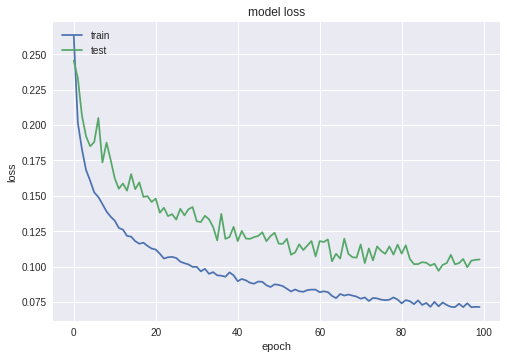

In [14]:

plt.plot(descriptor_history.history['loss'])
plt.plot(descriptor_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

np.save('data/net_loss.npy', np.array(descriptor_history.history['loss']))
np.save('data/net_val_loss.npy', np.array(descriptor_history.history['val_loss']))

In [15]:
from keras.models import load_model
from get_data import get_data
%cd hpatches-benchmark
!git pull 
%cd ..
!mkdir -p results

generate_desc_csv(descriptor_model, seqs_test, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

/content/deepLearning/hpatches-benchmark
Already up to date.
/content/deepLearning


100%|██████████| 40/40 [08:07<00:00,  8.24s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:41<00:00, 9892.83it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:44<00:00, 9609.45it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:43<00:00, 9621.83it/s]
>> Verification task finished in 318 secs  
Verification task results:
Mean Average Precision is 0.851414



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:13<00:00,  4.54s/it]
>> Matching task finished in 134 secs  
Matching task results:
Mean Average Precision is 0.274373





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large allo